## Imports

In [1]:
import os
from PIL import Image
from glob import glob
import scipy.misc
from scipy.misc import imread, imresize
from random import randrange, randint, uniform
import copy
import math 
%matplotlib inline

import numpy as np
import pandas as pd

In [3]:
from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet import MobileNet
# from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing import image
# from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Reshape, Activation
from keras.layers.core import Lambda
from keras.layers.pooling import MaxPool2D
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
import keras.backend as K
import tensorflow as tf

## Data

In [4]:
base_dir = os.getcwd()
data_dir = os.path.join(base_dir, 'data')
ori_dir = os.path.join(data_dir, 'ori')
ori_csv = os.path.join(ori_dir, 'orientations.csv')

In [5]:
os.chdir(ori_dir)
num = 3000
test = 500
files = sorted(glob("*.png"))
x = np.asarray([imresize(imread(file,mode='RGB'), (128,128)) for file in files[:num]])
x_test = np.asarray([imresize(imread(file,mode='RGB'), (128,128)) for file in files[num:num+test]])
df = pd.read_csv(ori_csv,delimiter=',')
os.chdir(base_dir)

In [6]:
df['roomba_rad'] = np.deg2rad(df['roomba_rotation'])
df['roomba_xhat'] = np.cos(df['roomba_rad'])
df['roomba_yhat'] = np.sin(df['roomba_rad'])

In [7]:
y = df[:num][['roomba_xhat', 'roomba_yhat']].values
y_test = df[num:num+test][['roomba_xhat', 'roomba_yhat']].values

## Model

### Choose layers

#### Mobilenet

In [38]:
output_num = 2
mobilenet = MobileNet(input_shape=(128,128,3),
                      alpha=1.00,
                      depth_multiplier=1,
                      dropout=1e-3,
                      include_top=False,
                      weights='imagenet',
                      input_tensor=None,
                      pooling='avg',
                      classes=1000)
mobile_layers = mobilenet.layers
final_layers = [Reshape((1, 1, -1), name='reshape_1'),
                Dropout(.001, name='dropout'),
#                 Conv2D(output_num, (1, 1), padding='same', name='conv_preds'),
                Dense(256, activation='relu', name='dense_1'),
                Dense(2, name='dense_2'),
                Activation('linear', name='act_linear'),
                Reshape((output_num,), name='reshape_2')]

layers = mobile_layers + final_layers
n = 5
for layer in layers[:-n]:
    layer.trainable = False
for layer in layers[-n:]:
    layer.trainable = True

#### VGG16

In [ ]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
vgg_preprocess = lambda x: (x - vgg_mean)[:, ::-1]
vgg16 = VGG16(include_top=True, weights='imagenet', pooling=None, input_shape=(224,224,3))
layers = [vgg16.layers[0]] + [Lambda(vgg_preprocess)] + vgg16.layers[1:-1] + [Dense(2, activation='relu')]

model = Sequential(layers=layers)
for layer in model.layers[:-2]:
    layer.trainable = False
for layer in model.layers[-2:]:
    layer.trainable = True
model.summary()

#### Custom

In [ ]:
layers = [Conv2D(16, (3,3), padding='same', input_shape=(128,128,3)),
          BatchNormalization(),
          Activation('relu'),
          MaxPool2D((2, 2), strides=(2, 2)),
          
          Conv2D(16, (3,3), padding='same'),
          BatchNormalization(),
          Activation('relu'),
          MaxPool2D((2, 2), strides=(2, 2)),
          
          Conv2D(16, (3,3), padding='same'),
          BatchNormalization(),
          Activation('relu'),
          MaxPool2D((2, 2), strides=(2, 2)),
          
          Conv2D(16, (3,3), padding='same'),
          BatchNormalization(),
          Activation('relu'),
          MaxPool2D((2, 2), strides=(2, 2)),
          
          Flatten(),
          Dense(1024),
          BatchNormalization(),
          Activation('relu'),
#           Dropout(.5),
          
          Dense(2),
         ]

### Make model

In [39]:
model = Sequential(layers)
model.compile(optimizer='adam',loss='mean_squared_error')

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 64, 64, 32)        0         
__________

## Train

In [41]:
model.fit(x, y, batch_size=16, epochs=10, validation_split=.2)

Train on 2400 samples, validate on 600 samples
Epoch 1/10
2400/2400 [==============================] - 3s - loss: 0.2799 - val_loss: 0.1368
Epoch 2/10
2400/2400 [==============================] - 2s - loss: 0.0610 - val_loss: 0.0511
Epoch 3/10
2400/2400 [==============================] - 2s - loss: 0.0415 - val_loss: 0.0220
Epoch 4/10
2400/2400 [==============================] - 2s - loss: 0.0319 - val_loss: 0.0169
Epoch 5/10
2400/2400 [==============================] - 2s - loss: 0.0279 - val_loss: 0.0175
Epoch 6/10
2400/2400 [==============================] - 2s - loss: 0.0237 - val_loss: 0.0155
Epoch 7/10
2400/2400 [==============================] - 2s - loss: 0.0208 - val_loss: 0.0151
Epoch 8/10
2400/2400 [==============================] - 2s - loss: 0.0173 - val_loss: 0.0107
Epoch 9/10
2400/2400 [==============================] - 2s - loss: 0.0163 - val_loss: 0.0134
Epoch 10/10
2400/2400 [==============================] - 2s - loss: 0.0138 - val_loss: 0.0084


## Test

In [18]:
def vecToAngle(vec):
    return np.degrees(np.arctan2(vec[1], vec[0]))

In [17]:
y_pred = model.predict(x_test)

True Angle 2.0
Pred Angle -7.65529


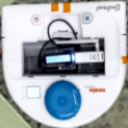

In [33]:
# n = 61
# n = 82
n = np.random.randint(test)
img = Image.fromarray(x_test[n])
print("True Angle", vecToAngle(y_test[n]))
print("Pred Angle", vecToAngle(y_pred[n]))
img

In [ ]:
y_pred.mean(axis=0)

In [ ]:
print(y_pred.mean(), y_pred.std())

## Export

In [ ]:
model.save('mobilenet_finetune.hdf5')